# KE5018 Time Series Forecasting

## Load Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load Data

In [2]:
train_ts_df = pd.read_csv('data/transformedTrainRatings.csv', index_col=0, parse_dates=True)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792


In [3]:
test_ts_df = pd.read_csv('data/transformedTestRatings.csv', index_col=0, parse_dates=True)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2008-11-02,72,02-Nov-2008 (45),206.61,1.676045
2008-11-09,73,09-Nov-2008 (46),188.68,1.671528
2008-11-16,74,16-Nov-2008 (47),197.64,1.673866
2008-11-23,75,23-Nov-2008 (48),193.16,1.672718
2008-11-30,76,30-Nov-2008 (49),184.74,1.670444


## Holt's Trend Corrected Two Parameter Exponential Smoothing

In [4]:
# For storing model results
results_list = []

### Use StatsModels to find the optimal weights for alpha and beta

In [5]:
# smoothing level = alpha (level), smoothing slope = beta (growth rate)
# The model will automatically optimize the value.
holt_train = sm.tsa.Holt(train_ts_df['GRP_boxcox'].values, exponential=True, damped=True).fit(optimized=True)
holt_train

In [6]:
holt_train.params

{'damping_slope': 0.73686703160926081,
 'initial_level': 1.6809632506711887,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 1.0017610694022359,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.63157083340723918,
 'smoothing_seasonal': nan,
 'smoothing_slope': 0.0,
 'use_boxcox': False}

### Manually Adjust Apha and Beta 

In [7]:
train_ts_df.tail()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2008-09-28,67,28-Sep-2008 (40),219.91,1.679017
2008-10-05,68,05-Oct-2008 (41),193.84,1.672895
2008-10-12,69,12-Oct-2008 (42),201.30,1.674773
2008-10-19,70,19-Oct-2008 (43),198.40,1.674056
2008-10-26,71,26-Oct-2008 (44),170.74,1.666279


In [8]:
holt_test = sm.tsa.Holt(test_ts_df['GRP_boxcox'].values,
                        exponential=True,
                        damped=True).fit(smoothing_level=holt_train.params['smoothing_level'],
                                         smoothing_slope=holt_train.params['smoothing_slope'],
                                         damping_slope=holt_train.params['damping_slope'],
                                         optimized=False)
holt_test

In [9]:
holt_test.params

{'damping_slope': 0.73686703160926081,
 'initial_level': 1.6760452873144036,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 0.99801320372797742,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.63157083340723918,
 'smoothing_seasonal': None,
 'smoothing_slope': 0.0,
 'use_boxcox': False}

In [10]:
BOXCOX_LAMBDA = -0.5677106

train_ts_df['holt'] = inv_boxcox(holt_train.predict(0, len(train_ts_df)-1), BOXCOX_LAMBDA)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt
weekly_date,,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670,240.728327
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012,251.608632
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067,266.191606
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303,274.239569
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792,264.433061


In [11]:
test_ts_df['holt'] = inv_boxcox(holt_test.predict(start=0, end=len(test_ts_df)-1), BOXCOX_LAMBDA)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt
weekly_date,,,,,
2008-11-02,72,02-Nov-2008 (45),206.61,1.676045,196.552917
2008-11-09,73,09-Nov-2008 (46),188.68,1.671528,195.541210
2008-11-16,74,16-Nov-2008 (47),197.64,1.673866,186.247591
2008-11-23,75,23-Nov-2008 (48),193.16,1.672718,189.611213
2008-11-30,76,30-Nov-2008 (49),184.74,1.670444,189.130812


In [12]:
test_ts_df['holt-outofsample'] = inv_boxcox(holt_train.predict(start=len(train_ts_df), end=len(train_ts_df) + len(test_ts_df)-1), BOXCOX_LAMBDA)
test_ts_df.tail()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt-outofsample
weekly_date,,,,,,
2009-02-15,87,15-Feb-2009 (8),204.20,1.675474,204.853902,180.638686
2009-02-22,88,22-Feb-2009 (9),200.61,1.674604,204.362817,180.638686
2009-03-01,89,01-Mar-2009 (10),208.56,1.676500,201.923807,180.638686
2009-03-08,90,08-Mar-2009 (11),191.74,1.672345,206.033031,180.638686
2009-03-15,91,15-Mar-2009 (12),222.07,1.679474,196.790567,180.638686


In [13]:
holt_train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['holt'].values)
holt_train_rmse = np.sqrt(holt_train_mse)
holt_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - train_ts_df['holt'].values) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
holt_test_mse = mean_squared_error(test_ts_df['GRP'].values, test_ts_df['holt'].values)
holt_test_rmse = np.sqrt(holt_test_mse)
holt_test_mape = np.sum(np.abs(test_ts_df['GRP'].values - test_ts_df['holt'].values) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100

results_list.append([holt_train_mse, holt_train_rmse, holt_train_mape, holt_test_mse, holt_test_rmse, holt_test_mape])

results_df = pd.DataFrame(results_list,
                          index=["Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised)"],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test mape
Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised),307.059562,17.523115,5.064089,236.840515,15.389624,5.434563


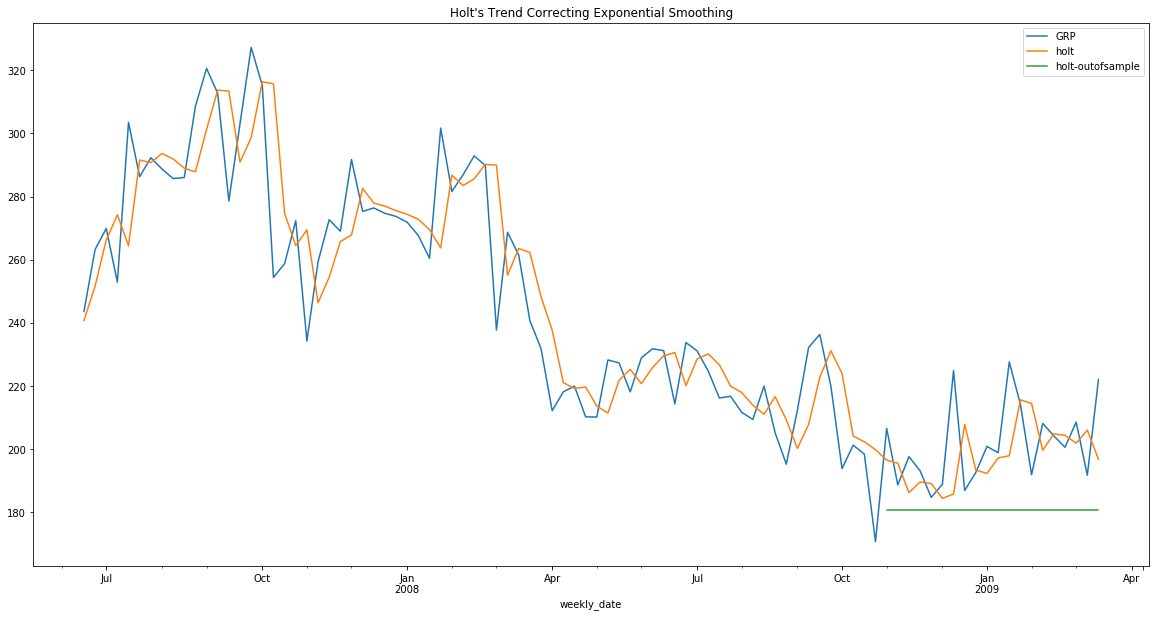

In [14]:
new_ts_df = train_ts_df.append(test_ts_df)
new_ts_df[['GRP', 'holt', 'holt-outofsample']].plot(figsize=(20, 10), title="Holt's Trend Correcting Exponential Smoothing")

In [15]:
residuals = train_ts_df['GRP'].values - train_ts_df['holt']
residuals[:10]

weekly_date
2007-06-17     2.871673
2007-06-24    11.581368
2007-07-01     3.698394
2007-07-08   -21.359569
2007-07-15    39.026939
2007-07-22    -5.248931
2007-07-29     1.536441
2007-08-05    -4.894819
2007-08-12    -6.199094
2007-08-19    -2.959159
Name: holt, dtype: float64

In [16]:
holt_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=False))])
holt_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
holt_res_pred = holt_res.predict(train_ts_df['week'].values.reshape(-1, 1))

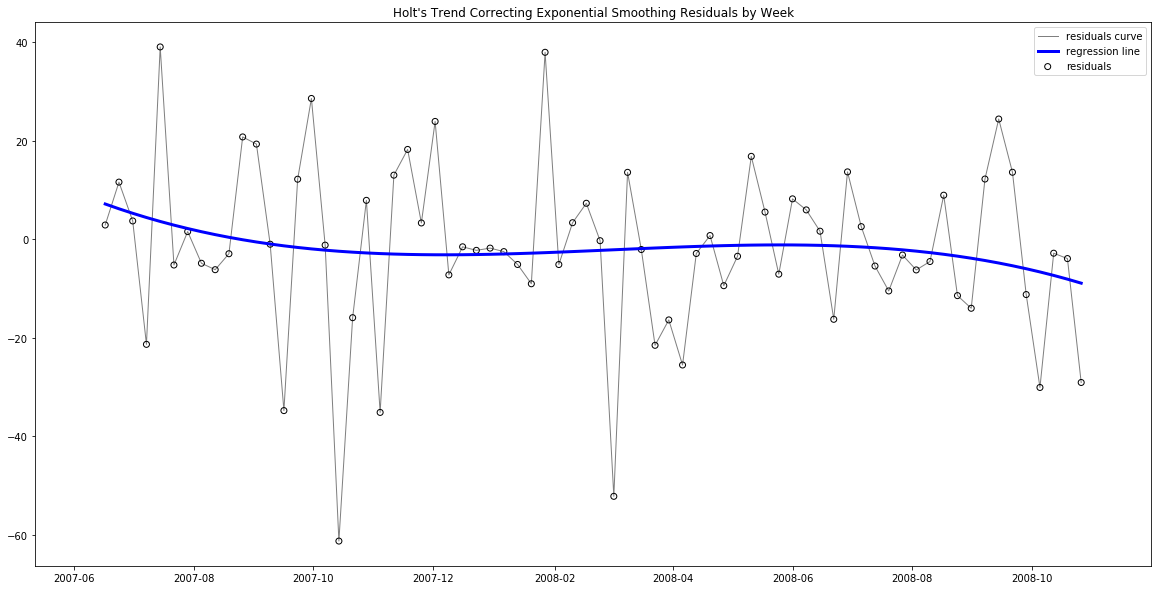

In [17]:
plt.figure(figsize=(20, 10))
plt.title("Holt's Trend Correcting Exponential Smoothing Residuals by Week")
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, holt_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

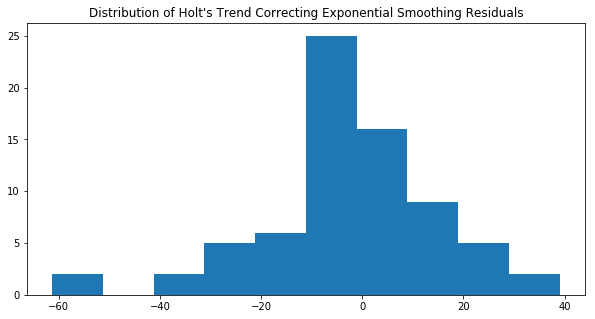

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of Holt's Trend Correcting Exponential Smoothing Residuals")
plt.hist(residuals)
plt.show()

In [19]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,0.000332,0.985463
1,2,3.997764,0.135487
2,3,4.324373,0.228501
3,4,5.144769,0.272763
4,5,5.878019,0.318270
5,6,6.547302,0.364746
6,7,7.819061,0.348819
7,8,7.819062,0.451342
8,9,8.150425,0.519061
9,10,8.179441,0.611314


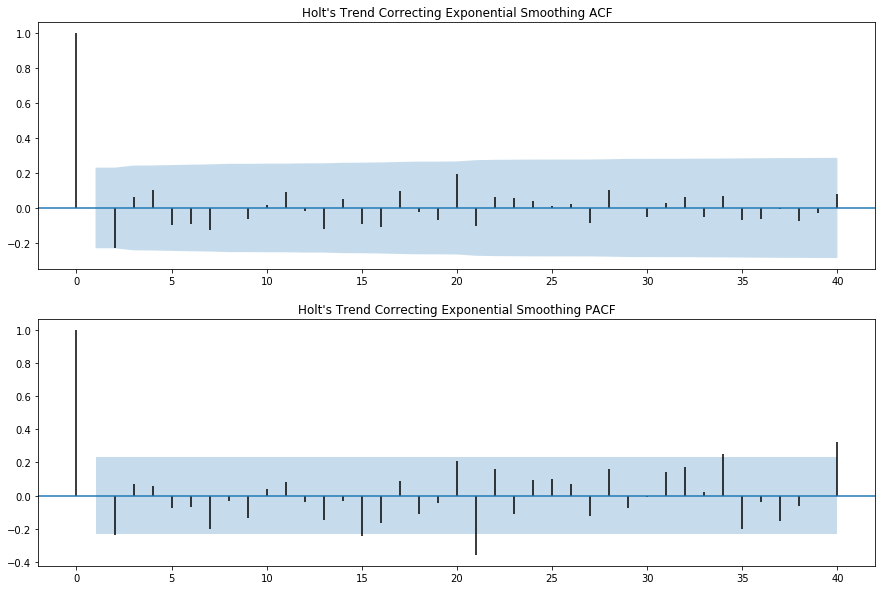

In [20]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=40, title="Holt's Trend Correcting Exponential Smoothing ACF", marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=40, title="Holt's Trend Correcting Exponential Smoothing PACF", marker=None)
plt.show()

The residuals are close to gaussian distribution and show no autocorrelation. The model fits well.

### Manually Adjust Apha and Beta 

In [21]:
# smoothing level = alpha (level), smoothing slope = beta (growth rate)
holt1_train = sm.tsa.Holt(train_ts_df['GRP_boxcox'].values, exponential=True, damped=False).fit(smoothing_level=.8, smoothing_slope=.1, damping_slope=.1, optimized=False)
holt1_train

In [22]:
holt1_train.params

{'damping_slope': nan,
 'initial_level': 1.6836695615279251,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 1.0019849683556756,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.8,
 'smoothing_seasonal': None,
 'smoothing_slope': 0.1,
 'use_boxcox': False}

In [23]:
train_ts_df['holt1'] = inv_boxcox(holt1_train.predict(0, len(train_ts_df)-1), BOXCOX_LAMBDA)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt1
weekly_date,,,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670,240.728327,263.190000
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012,251.608632,265.713733
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067,266.191606,283.868786
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303,274.239569,292.671010
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792,264.433061,275.462913


In [24]:
train_ts_df.tail()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt1
weekly_date,,,,,,
2008-09-28,67,28-Sep-2008 (40),219.91,1.679017,231.157581,236.178305
2008-10-05,68,05-Oct-2008 (41),193.84,1.672895,223.952093,223.237093
2008-10-12,69,12-Oct-2008 (42),201.30,1.674773,204.152425,197.221955
2008-10-19,70,19-Oct-2008 (43),198.40,1.674056,202.343606,198.785890
2008-10-26,71,26-Oct-2008 (44),170.74,1.666279,199.838809,196.785379


In [25]:
holt1_test = sm.tsa.Holt(test_ts_df['GRP_boxcox'].values,
                        exponential=True,
                        damped=False).fit(smoothing_level=holt1_train.params['smoothing_level'],
                                         smoothing_slope=holt1_train.params['smoothing_slope'],
                                         damping_slope=holt1_train.params['damping_slope'],
                                         optimized=False)
holt1_test

In [26]:
holt1_test.params

{'damping_slope': nan,
 'initial_level': 1.6760452873144036,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 0.99730468172479525,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.8,
 'smoothing_seasonal': None,
 'smoothing_slope': 0.1,
 'use_boxcox': False}

In [27]:
test_ts_df['holt1'] = inv_boxcox(holt1_test.predict(start=0, end=len(test_ts_df)-1), BOXCOX_LAMBDA)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt-outofsample,holt1
weekly_date,,,,,,,
2008-11-02,72,02-Nov-2008 (45),206.61,1.676045,196.552917,180.638686,188.680000
2008-11-09,73,09-Nov-2008 (46),188.68,1.671528,195.541210,180.638686,186.701343
2008-11-16,74,16-Nov-2008 (47),197.64,1.673866,186.247591,180.638686,174.073104
2008-11-23,75,23-Nov-2008 (48),193.16,1.672718,189.611213,180.638686,179.606365
2008-11-30,76,30-Nov-2008 (49),184.74,1.670444,189.130812,180.638686,178.631920


In [28]:
test_ts_df['holt1-outofsample'] = inv_boxcox(holt1_train.predict(start=len(train_ts_df), end=len(train_ts_df) + len(test_ts_df)-1), BOXCOX_LAMBDA)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt-outofsample,holt1,holt1-outofsample
weekly_date,,,,,,,,
2008-11-02,72,02-Nov-2008 (45),206.61,1.676045,196.552917,180.638686,188.680000,172.211597
2008-11-09,73,09-Nov-2008 (46),188.68,1.671528,195.541210,180.638686,186.701343,169.021252
2008-11-16,74,16-Nov-2008 (47),197.64,1.673866,186.247591,180.638686,174.073104,165.924450
2008-11-23,75,23-Nov-2008 (48),193.16,1.672718,189.611213,180.638686,179.606365,162.917483
2008-11-30,76,30-Nov-2008 (49),184.74,1.670444,189.130812,180.638686,178.631920,159.996823


In [29]:
holt1_train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['holt1'].values)
holt1_train_rmse = np.sqrt(holt_train_mse)
holt1_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - train_ts_df['holt1'].values) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
holt1_test_mse = mean_squared_error(test_ts_df['GRP'].values, test_ts_df['holt1'].values)
holt1_test_rmse = np.sqrt(holt1_test_mse)
holt1_test_mape = np.sum(np.abs(test_ts_df['GRP'].values - test_ts_df['holt1'].values) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100

results_list.append([holt1_train_mse, holt1_train_rmse, holt1_train_mape, holt1_test_mse, holt1_test_rmse, holt1_test_mape])

In [30]:
results_df = pd.DataFrame(results_list,
                          index=["Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised)",
                                 "Holt's Trend Corrected Exponential Smoothing (Manually Adjusted)"],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test mape
Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised),307.059562,17.523115,5.064089,236.840515,15.389624,5.434563
Holt's Trend Corrected Exponential Smoothing (Manually Adjusted),402.743313,17.523115,5.880148,387.920308,19.695693,7.608155


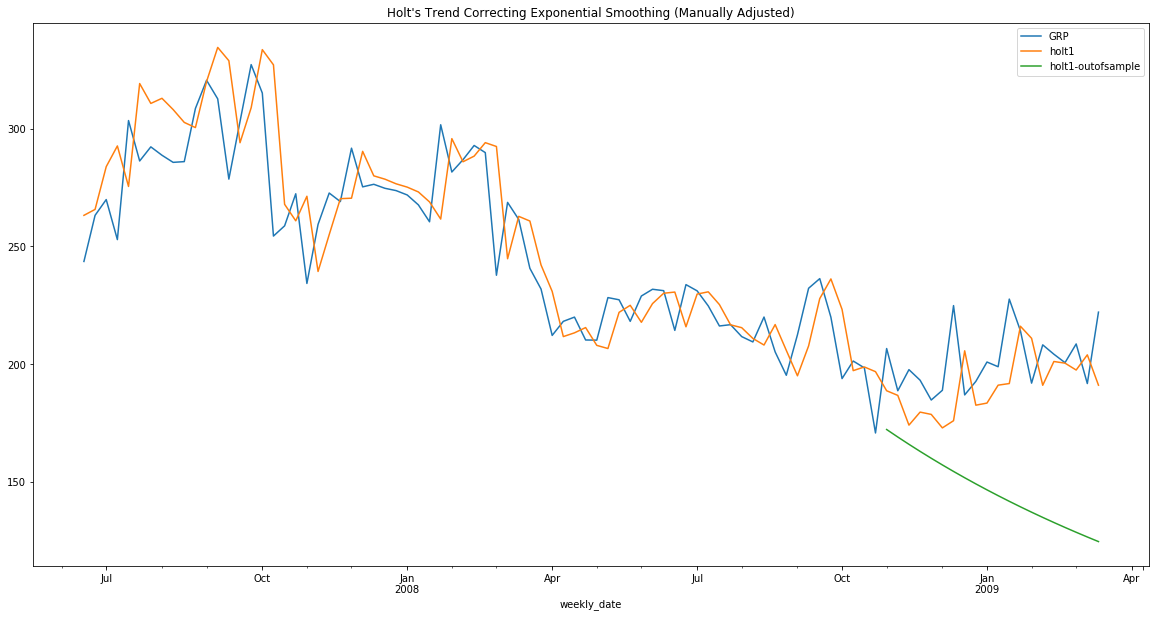

In [31]:
new_ts_df = train_ts_df.append(test_ts_df)
new_ts_df[['GRP', 'holt1', 'holt1-outofsample']].plot(figsize=(20, 10), title="Holt's Trend Correcting Exponential Smoothing (Manually Adjusted)")

## Additive Holt-Winters Method (three parameters)

### Reload the Data

In [32]:
# This is the seasonal period used in the model
FREQ = 20

train_ts_df = pd.read_csv('data/transformedTrainRatings.csv', index_col=0, parse_dates=True)
test_ts_df = pd.read_csv('data/transformedTestRatings.csv', index_col=0, parse_dates=True)

We use the same 5 month (5 x 4 = 20 periods) season from the dummy variable linear regression and decomposition method.

In [33]:
# *** Using multiplicative and damped=True produces errors. ***
hw_train = sm.tsa.ExponentialSmoothing(train_ts_df['GRP_boxcox'], trend="additive", damped=False, seasonal="additive", seasonal_periods=FREQ).fit(optimized=True)
hw_train

/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [34]:
hw_train.params

{'damping_slope': nan,
 'initial_level': 1.6813559719880868,
 'initial_seasons': array([ 0.00231362,  0.00565559,  0.00671049,  0.00394738,  0.01143629,
         0.00912782,  0.00995729,  0.00946758,  0.00904464,  0.00908841,
         0.01208673,  0.01354157,  0.01259211,  0.00801925,  0.01138492,
         0.01431301,  0.01289296,  0.00420432,  0.00492978,  0.00708763]),
 'initial_slope': 0.0,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.78947485529023542,
 'smoothing_seasonal': 0.21053070733838258,
 'smoothing_slope': 0.052631577564696032,
 'use_boxcox': False}

In [35]:
train_ts_df['hw'] = inv_boxcox(hw_train.predict(0, len(train_ts_df)-1), BOXCOX_LAMBDA)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,hw
weekly_date,,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670,243.600187
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012,263.189663
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067,269.889671
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303,252.880597
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792,303.459224


In [36]:
train_ts_df.tail()

,week,GRPRatingsDate,GRP,GRP_boxcox,hw
weekly_date,,,,,
2008-09-28,67,28-Sep-2008 (40),219.91,1.679017,239.240050
2008-10-05,68,05-Oct-2008 (41),193.84,1.672895,218.041093
2008-10-12,69,12-Oct-2008 (42),201.30,1.674773,194.334087
2008-10-19,70,19-Oct-2008 (43),198.40,1.674056,208.971930
2008-10-26,71,26-Oct-2008 (44),170.74,1.666279,204.493613


In [37]:
# Add the last train observation to test dataset to make it 40 observations. Less than this fitting the exponential smoothing breaks.
# cols = test_ts_df.columns.tolist()
# a_test_ts_df = pd.concat([train_ts_df[len(train_ts_df) - 1:], test_ts_df])
# a_test_ts_df = a_test_ts_df[cols]
# a_test_ts_df.head()

In [38]:
all_ts_df = pd.read_csv('data/transformedRatings.csv', index_col=0, parse_dates=True)
all_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792


In [39]:
hw_test = sm.tsa.ExponentialSmoothing(all_ts_df['GRP_boxcox'], trend="additive", damped=False,
                                      seasonal="additive", seasonal_periods=FREQ).fit(
    smoothing_level=hw_train.params['smoothing_level'],
    smoothing_slope=hw_train.params['smoothing_slope'],
    smoothing_seasonal=hw_train.params['smoothing_seasonal'],
    damping_slope=hw_train.params['damping_slope'],
    optimized=False)

all_ts_df['hw'] = inv_boxcox(hw_test.predict(0, len(all_ts_df) - 1), BOXCOX_LAMBDA)

a_test_ts_df = all_ts_df.loc['18/6/2008':].copy()
a_test_ts_df.head()


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


,week,GRPRatingsDate,GRP,GRP_boxcox,hw
weekly_date,,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,205.642631
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,221.174191
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,244.698027
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,228.187675
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215,187.052132


In [40]:
a_test_ts_df['hw-outofsample'] = inv_boxcox(hw_train.predict(start=len(train_ts_df)-1, end=len(train_ts_df) + len(a_test_ts_df)-2), BOXCOX_LAMBDA)
a_test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,hw,hw-outofsample
weekly_date,,,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,205.642631,NaN
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,221.174191,NaN
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,244.698027,NaN
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,228.187675,NaN
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215,187.052132,NaN


In [41]:
hw_train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['hw'].values)
hw_train_rmse = np.sqrt(hw_train_mse)
hw_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - train_ts_df['hw'].values) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
hw_test_mse = mean_squared_error(a_test_ts_df['GRP'].values, a_test_ts_df['hw'].values)
hw_test_rmse = np.sqrt(hw_test_mse)
hw_test_mape = np.nansum(np.abs(a_test_ts_df['GRP'].values - a_test_ts_df['hw'].values) / a_test_ts_df['GRP'].values) / len(a_test_ts_df['GRP'].values) * 100

results_list.append([hw_train_mse, hw_train_rmse, hw_train_mape, hw_test_mse, hw_test_rmse, hw_test_mape])

In [42]:
results_df = pd.DataFrame(results_list,
                          index=["Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised)",
                                 "Holt's Trend Corrected Exponential Smoothing (Manually Adjusted)",
                                 "Additive Holt's & Winter's Method"],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test mape
Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised),307.059562,17.523115,5.064089,236.840515,15.389624,5.434563
Holt's Trend Corrected Exponential Smoothing (Manually Adjusted),402.743313,17.523115,5.880148,387.920308,19.695693,7.608155
Additive Holt's & Winter's Method,204.891608,14.314035,4.043986,357.924700,18.918898,7.331591


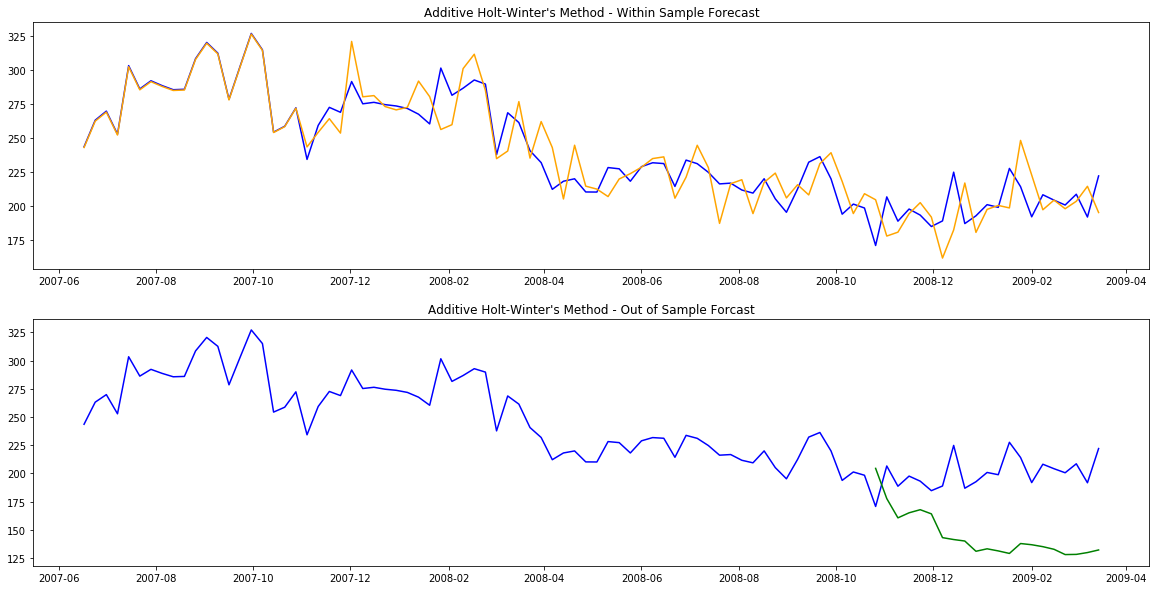

In [43]:
#new_ts_df = train_ts_df.append(a_test_ts_df)

plt.figure(figsize=(20, 10))
plt.subplot(211)
#plt.plot(new_ts_df['GRP'], color='blue')
plt.plot(all_ts_df['GRP'], color='blue')
#plt.plot(new_ts_df['hw'], color='orange')
plt.plot(all_ts_df['hw'], color='orange')
plt.title("Additive Holt-Winter's Method - Within Sample Forecast")
plt.subplot(212)
#plt.plot(new_ts_df['GRP'], color='blue')
#plt.plot(new_ts_df['hw-outofsample'], color='green')
plt.plot(all_ts_df['GRP'], color='blue')
plt.plot(a_test_ts_df['hw-outofsample'], color='green')
plt.title("Additive Holt-Winter's Method - Out of Sample Forcast")
plt.show()

In [44]:
residuals = train_ts_df['GRP'].values - train_ts_df['hw']
residuals[:10]

weekly_date
2007-06-17   -0.000187
2007-06-24    0.000337
2007-07-01    0.000329
2007-07-08   -0.000597
2007-07-15    0.000776
2007-07-22   -0.000488
2007-07-29    0.000071
2007-08-05   -0.000188
2007-08-12    0.000023
2007-08-19   -0.000194
Name: hw, dtype: float64

In [45]:
hw_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=False))])
hw_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
hw_res_pred = hw_res.predict(train_ts_df['week'].values.reshape(-1, 1))

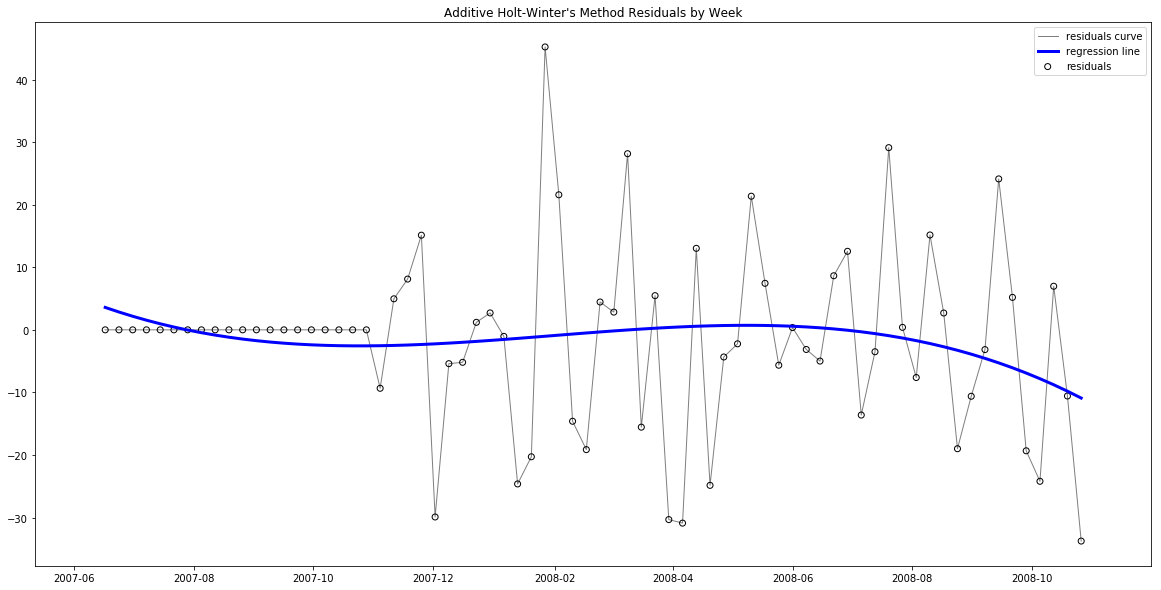

In [46]:

plt.figure(figsize=(20, 10))
plt.title("Additive Holt-Winter's Method Residuals by Week")
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, hw_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

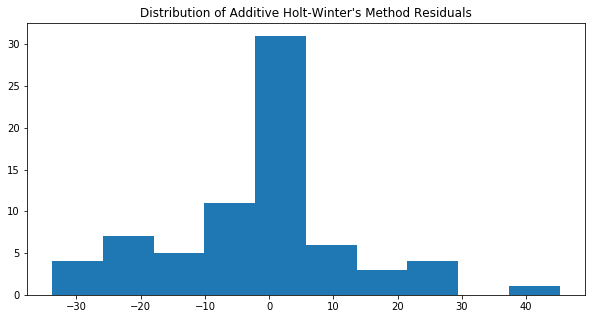

In [47]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of Additive Holt-Winter's Method Residuals")
plt.hist(residuals)
plt.show()

In [48]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,0.086402,0.768802
1,2,7.360744,0.025214
2,3,8.176525,0.042501
3,4,9.066773,0.059452
4,5,9.671190,0.085106
5,6,9.694029,0.138143
6,7,9.702485,0.206070
7,8,12.070450,0.148088
8,9,12.239302,0.200152
9,10,12.689856,0.241533


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


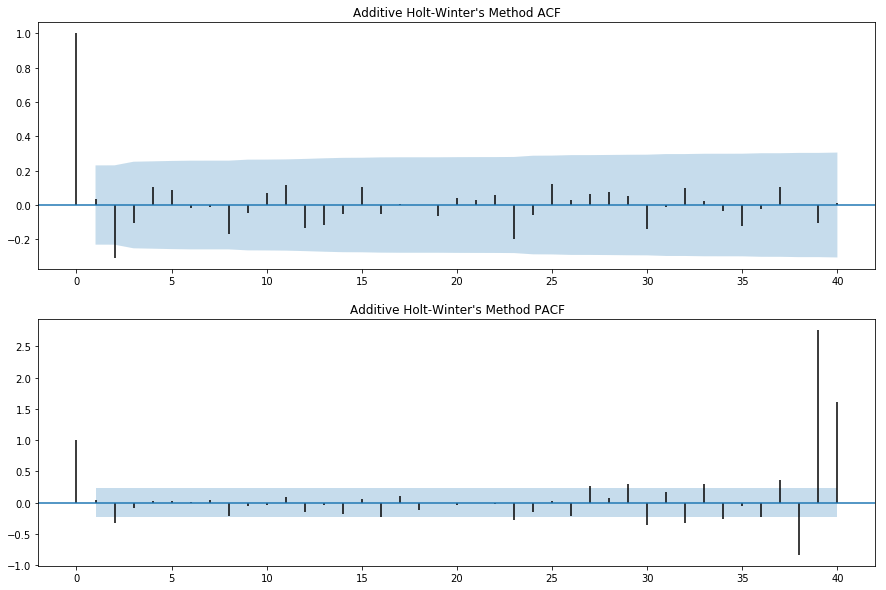

In [49]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=40, title="Additive Holt-Winter's Method ACF", marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=40, title="Additive Holt-Winter's Method PACF", marker=None)
plt.show()

## Conclusion

In [50]:
results_df = pd.DataFrame(results_list,
                          index=["Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised)",
                                 "Holt's Trend Corrected Exponential Smoothing (Manually Adjusted)",
                                 "Additive Holt's & Winter's Method"
                                 ],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test mape
Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised),307.059562,17.523115,5.064089,236.840515,15.389624,5.434563
Holt's Trend Corrected Exponential Smoothing (Manually Adjusted),402.743313,17.523115,5.880148,387.920308,19.695693,7.608155
Additive Holt's & Winter's Method,204.891608,14.314035,4.043986,357.924700,18.918898,7.331591
